<div style="float:right; width:100px; text-align: center; margin: 10px;">
<img src="https://crypto-lake.com/assets/img/lake.png" alt="Lake"/>
</div>

# HFT backtest example

We use [crypto-lake.com](https://crypto-lake.com/#data) sample/free market data.

Quick links:
- [edit this notebook online](https://mybinder.org/v2/gh/crypto-lake/analysis-sharing/main?filepath=hftbacktest.ipynb) using Binder
- [follow our activity on twitter](https://twitter.com/intent/user?screen_name=crypto_lake_com)

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import datetime

import pandas as pd
import lakeapi
import hftbacktest
import lake_to_hftbacktest
from numba import njit

# lakeapi.use_sample_data(anonymous_access=True)


In [3]:
# Parameters
symbol = 'SOL-USDT'
exchange = 'BINANCE'


# Free sample data contain subset of the below time period
start = datetime.datetime(2023, 12, 20)
end = datetime.datetime(2023, 12, 22)


## Data

In [4]:
print('Loading data')
trades = lakeapi.load_data(
    table = 'trades',
    start = start,
    end = end,
    symbols = [symbol],
    exchanges = [exchange],
    drop_partition_cols = True,
).sort_values('received_time')
book = lakeapi.load_data(
    table = 'book_delta_v2',
    start = start,
    end = end,
    symbols = [symbol],
    exchanges = [exchange],
    drop_partition_cols = True,
).sort_values('received_time')


Loading data


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
book.memory_usage(deep=True).sum() / 1024**2


796.1572408676147

In [6]:
# Wrong local-exchange time diff
trades[trades.received_time < trades.origin_time][::100]


,side,quantity,price,trade_id,origin_time,received_time
50477,buy,0.26,75.08,273042300,2023-12-20 04:19:48.719000064,2023-12-20 04:19:48.718803968
84634,sell,26.42,75.67,273076457,2023-12-20 07:17:26.040000000,2023-12-20 07:17:26.039465216
85716,sell,197.77,75.59,273077539,2023-12-20 07:25:42.822000128,2023-12-20 07:25:42.821731840
86333,buy,0.70,75.51,273078156,2023-12-20 07:32:31.742000128,2023-12-20 07:32:31.741917440
86688,sell,0.98,75.48,273078511,2023-12-20 07:36:05.150000128,2023-12-20 07:36:05.149893632
...,...,...,...,...,...,...
209636,buy,0.31,78.91,273203355,2023-12-20 14:08:39.488000000,2023-12-20 14:08:39.486791168
210418,sell,4.20,79.04,273204137,2023-12-20 14:10:25.019000064,2023-12-20 14:10:25.018881024
211078,sell,1.26,78.74,273204797,2023-12-20 14:12:34.342999808,2023-12-20 14:12:34.342224128
211974,sell,2.00,78.59,273205693,2023-12-20 14:15:10.252000000,2023-12-20 14:15:10.251852800


In [7]:
ret = None
def convert():
	global ret
	ret = lake_to_hftbacktest.convert(
		input_dfs = [book, trades],
		output_filename = 'hftbacktest_data.npz',
		method = 'keep',
	)

# %prun convert()
convert()


  0%|          | 0/17037375 [00:00<?, ?it/s]

  0%|          | 0/1162256 [00:00<?, ?it/s]

Merging 1703237967.0982947
Correcting 1703237968.7492285
local_timestamp is ahead of exch_timestamp by 9905664.0
1703237970.221567
found 217266 rows that exch_timestamp is ahead of the previous exch_timestamp
Correction is done.
1703237970.5612276
Saving to hftbacktest_data.npz
1703237972.0816455


In [8]:
np.set_printoptions(
	# suppress=True,
	linewidth=180,
	# precision=9,
)
# (ret[10000:11000:100][:, [1,2]] / 1e9).astype(int)
# (ret[2000:12000:1000][:, [1,2]] / 1e9).astype(int)
# ret[9000:11000:100].astype(int)


## Try out the data


In [9]:
hbt = hftbacktest.HftBacktest(
    'hftbacktest_data.npz',
    tick_size=0.01,   # Tick size of a target trading asset
    lot_size=1,    # Lot size of a target trading asset, minimum trading unit.
    maker_fee=0.0002, # 0.02%, Maker fee, rebates if it is negative.
    taker_fee=0.0007, # 0.07%, Taker fee.
    order_latency=hftbacktest.FeedLatency(), # Latency model: ConstantLatency, FeedLatency.
    asset_type=hftbacktest.Linear, # Asset type: Linear, Inverse.
)


Load hftbacktest_data.npz


In [15]:
@njit(cache=True)
def dca_every_10m(hbt, recorder):
    ''' DCA with 10min frequency using limit order on best bid '''
    order_id = 1
    while hbt.run:
        # Times are in nanoseconds
        if not hbt.elapse(10 * 60 * 1e9):
            return False
        if hbt.best_bid < 0:
            # We don't have data at the moment
            continue

        print(
            'timestamp_s:', hbt.current_timestamp // 1e9,
            ', best_bid:', round(hbt.best_bid, 9),
            ', best_ask:', round(hbt.best_ask, 9),
            ', position:', hbt.position,
            ', equity:', hbt.equity,
        )
        # Record statistics for analysis in the next cell
        recorder.record(hbt)
        hbt.clear_inactive_orders()
        # Try to buy some tokens every 10 minutes
        hbt.submit_buy_order(order_id, hbt.best_bid, 10, hftbacktest.GTC)
        order_id += 1
    return True


if not hbt.run:
	# If backtest already run and finished, reset it to be able to run this cell again
	hftbacktest.reset(hbt, 'hftbacktest_data.npz')

print('Running backtest')
stat = hftbacktest.Stat(hbt, unit = 'ns')
dca_every_10m(hbt, stat.recorder)


Load hftbacktest_data.npz
Running backtest
timestamp_s: 1703074201.0 , best_bid: 76.62 , best_ask: 76.63 , position: 0.0 , equity: 0.0
timestamp_s: 1703074801.0 , best_bid: 76.7 , best_ask: 76.71 , position: 10.0 , equity: 0.6967600000001364
timestamp_s: 1703075401.0 , best_bid: 76.9 , best_ask: 76.91 , position: 10.0 , equity: 2.6967599999999092
timestamp_s: 1703076001.0 , best_bid: 76.89 , best_ask: 76.9 , position: 20.0 , equity: 2.3929600000000453
timestamp_s: 1703076601.0 , best_bid: 76.86 , best_ask: 76.87 , position: 30.0 , equity: 1.3891800000003638
timestamp_s: 1703077201.0 , best_bid: 77.04 , best_ask: 77.05 , position: 40.0 , equity: 8.485460000000364
timestamp_s: 1703077801.0 , best_bid: 77.79 , best_ask: 77.8 , position: 50.0 , equity: 45.88138000000009
timestamp_s: 1703078401.0 , best_bid: 78.08 , best_ask: 78.09 , position: 60.0 , equity: 63.175800000000365
timestamp_s: 1703079001.0 , best_bid: 78.2 , best_ask: 78.21 , position: 70.0 , equity: 71.46964000000109
timestamp

False

=========== Summary ===========
Sharpe ratio: 26.3
Sortino ratio: 50.0
Risk return ratio: 934.5
Annualised return: 4449.78 %
Max. draw down: 4.76 %
The number of trades per day: 93
Avg. daily trading volume: 936
Avg. daily trading amount: 77741
Max leverage: 1.95
Median leverage: 0.88


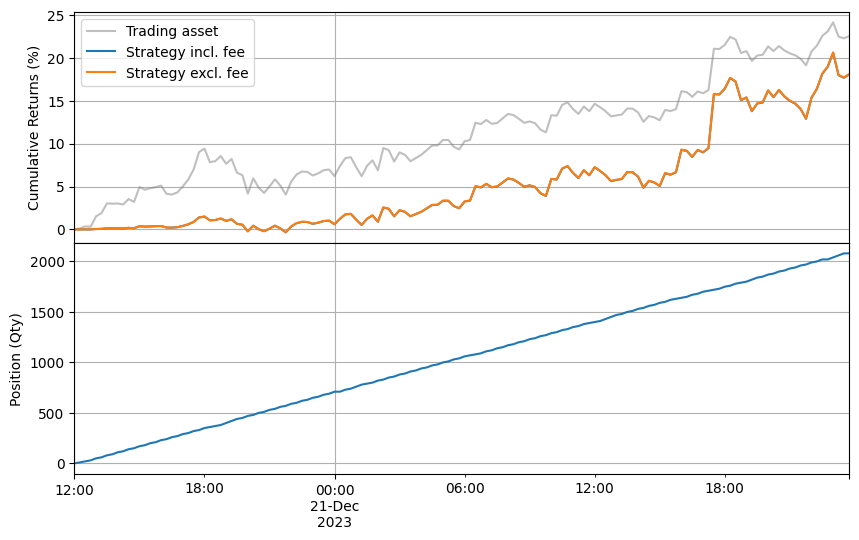

In [17]:
stat.summary(capital=100_000, resample='15min')


In [18]:
# DEBUG: Show notebook locals sorted by size
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                          book: 796.2 MiB
                        trades: 62.1 MiB
                            _6: 16.9 KiB
                          _i13:  1.2 KiB
                          _i10:  1.2 KiB
                          _iii:  1.2 KiB
                          _i15:  1.2 KiB
                           _i4:  684.0 B
                          _i12:  640.0 B
                          _i18:  640.0 B
